In [154]:

import numpy as np
from ase.neighborlist import NeighborList, natural_cutoffs

class AtomFeatures:
    def __init__(self, atoms, natural_cutoff_factor=1):
        self.atoms = atoms
        self.natural_cutoff_factor = natural_cutoff_factor
        self.neighbor_list = self.create_neighbor_list()
    
    def get_atom_index(self, interest):
        """
        interest: str or int
            If str, the symbol of the atom of interest.
            If int, the index of the atom of interest.
        """
        if isinstance(interest, str):
            atom_index = next((i for i, atom in enumerate(self.atoms) if atom.symbol == interest), None)
            if atom_index is None:
                raise ValueError(f"No atom with symbol {interest} found.")
        elif isinstance(interest, (int, np.integer)):
            atom_index = interest
        else:
            raise ValueError("Interest must be a string (atom symbol) or an integer (atom index).")
        return atom_index
    
    def create_neighbor_list(self):
        """
        Create a NeighborList object for the atoms object.
            natural_cutoff_factor: float
        """
        cutoffs = natural_cutoffs(self.atoms)
        nl = NeighborList([c * self.natural_cutoff_factor for c in cutoffs], self_interaction=False, bothways=True)
        nl.update(self.atoms)
        return nl
    
    def filter_neighbors(self, atom_index, avoid):
        """
        Filter the neighboring atoms of the atom of interest.
            nl: NeighborList object
            atom_index: int
            atoms: list of ase.Atom objects
            avoid: list of str
                List of atom symbols to avoid. Useful for filtering adsorbate atoms.
        """
        indices, _ = self.neighbor_list.get_neighbors(atom_index)
        filtered_indices = [i for i in indices if self.atoms[i].symbol not in avoid]
        neighboring_atoms = [self.atoms[i].symbol for i in filtered_indices]
        return neighboring_atoms, filtered_indices
    
    def find_neighboring_atoms(self, interest, avoid=[]):
        atom_index = self.get_atom_index(interest)
        neighboring_atoms, filtered_indices = self.filter_neighbors(atom_index, avoid)
        return neighboring_atoms, filtered_indices

    def get_surface_atoms(self, cutoff_cn=12):
        """ 
        Identify surface atoms based on coordination number. 
            natural_cutoff_factor: float - factor to multiply the natural cutoffs by
            cutoff_cn: int - coordination number cutoff for surface atoms
        """
        surface_atoms = []
        for i, atom in enumerate(self.atoms):
            if len(self.neighbor_list.get_neighbors(i)[0]) < cutoff_cn:
                surface_atoms.append(i)
        return surface_atoms

class FeatureCreator:
    def __init__(self, df):
        self.df = df

    def binding_atoms_per_type(self, atoms, ads, metaltype):
        """
        Count the number of specified metal atoms bonded to the adsorbate atom.
            ads: str or int - symbol or index of the adsorbate atom
            metaltype: str - symbol of the metal atom
        """
        af = AtomFeatures(atoms)
        binding_metals, _ = af.find_neighboring_atoms(interest=ads, avoid=[])
        count = len([m for m in binding_metals if m == metaltype])
        return count
    
    def neighbor_count_per_type(self, atoms, ads, metal):
        """
        Count the number of specified metal atoms neighboring the adsorbate atom's neighbors.
            ads: str or int - symbol or index of the adsorbate atom
            metal: str - symbol of the metal atom
        """
        af = AtomFeatures(atoms)
        _, bm_indices = af.find_neighboring_atoms(interest=ads, avoid=[])
        neigh_indexes = []
        metal_symb = []
        for i in bm_indices:
            mneigh, mn_indices = af.find_neighboring_atoms(interest=i, avoid=[ads])
            for j, index in enumerate(mn_indices):
                if index not in neigh_indexes and index not in bm_indices:
                    neigh_indexes.append(index)
                    metal_symb.append(mneigh[j])
        count = len([m for m in metal_symb if m == metal])
        return count

    def add_bonding_features(self, metals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'], ads='N'):
        """
        Add bonding features to the dataframe for specified metals.
        """
        for metal in metals:
            self.df[f'bonding_{metal}'] = self.df.apply(lambda x: self.binding_atoms_per_type(x.Atoms, ads=ads, metaltype=metal), axis=1)

    def add_neigh_features(self, metals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'], ads='N'):
        """
        Add neighboring features to the dataframe for specified metals.
        """
        for metal in metals:
            self.df[f'neigh_{metal}'] = self.df.apply(lambda x: self.neighbor_count_per_type(x.Atoms, ads=ads, metal=metal), axis=1)

In [1]:
from asetools.analysis import check_outcar_convergence
import glob
import pandas as pd
from ase.io import read

mainfolders = {
    'N': '/Users/juanito/OneDrive_ASTAR/work/computers/HEA/NewCalc_JA/99_N_ads',
    'CO': '/Users/juanito/OneDrive_ASTAR/work/computers/HEA/NewCalc_JA/01_rough_opt',
    }

# list directories inside mainfolder
listdirs = []
df_full = pd.DataFrame()

for ads, mainfolder in mainfolders.items():
    dirs = glob.glob(mainfolder + '/*/')

    for d in dirs:
        calcfolders = glob.glob(d + '*/')
        for calc in calcfolders:
            try:
                outcar = calc + 'OUTCAR'
                convergence, vasp = check_outcar_convergence(outcar, verbose=False)
            except:
                convergence = False
                vasp = 'Error'
            #print(d.split('/')[-2], calc.split('/')[-2], convergence, vasp)

            if convergence:
                outcar = calc + 'OUTCAR'
                atoms = read(outcar, format='vasp-out', index=-1)
                # append to dataframe
                _df = pd.DataFrame.from_dict({
                                        'ads': ads,
                                        'NP': d.split('/')[-2],
                                        'AdsConfig': calc.split('/')[-2], 
                                        'Convergence': convergence,
                                        'Energy': atoms.get_potential_energy(),
                                        'Atoms': atoms}, orient='index').T
                df_full = pd.concat([df_full, pd.DataFrame(_df, index=[0])], ignore_index=True)

In [2]:
df_full

,ads,NP,AdsConfig,Convergence,Energy,Atoms
0,N,MS,61,True,-178.925206,"(Atom('Cu', [12.29353, 10.04312, 11.43018], in..."
1,N,MS,59,True,-178.477362,"(Atom('Cu', [12.29447, 9.99291, 11.41855], ind..."
2,N,MS,66,True,-178.057637,"(Atom('Cu', [12.26958, 10.02349, 11.4701], ind..."
3,N,MS,50,True,-179.153085,"(Atom('Cu', [12.2886, 10.00522, 11.44912], ind..."
4,N,MS,68,True,-178.013614,"(Atom('Cu', [12.27315, 10.03009, 11.47151], in..."
...,...,...,...,...,...,...
671,CO,34152,Au_02,True,-186.498244,"(Atom('Cu', [12.2845, 9.97381, 11.41906], inde..."
672,CO,34152,Pd_06,True,-186.778163,"(Atom('Cu', [12.28945, 9.96446, 11.41377], ind..."
673,CO,34152,Pt_03,True,-187.052565,"(Atom('Cu', [12.28997, 9.95868, 11.42382], ind..."
674,CO,34152,Pt_04,True,-187.609826,"(Atom('Cu', [12.29504, 9.95756, 11.43084], ind..."


In [3]:
ref = {'AS': -171.092, 'LS': -170.383, 'MS': -172.001, 
       '23154': -171.081, '31245': -171.070, '34152': -171.076, '43125': -171.113,
       'LSminus1': -170.513}

gas_e = {
       'CO': -14.424,
       'N': -16.2698 / 2,   # original is N2 gas
       }

df_full['Eads'] = df_full.apply(lambda x: x.Energy - ref[x.NP] - gas_e[x.ads], axis=1)
# Feature 'ads' with 'N' and 'CO' should be converted to numerical values
df_full = pd.get_dummies(df_full, columns=['ads'])
df_full

,NP,AdsConfig,Convergence,Energy,Atoms,Eads,ads_CO,ads_N
0,MS,61,True,-178.925206,"(Atom('Cu', [12.29353, 10.04312, 11.43018], in...",1.210694,False,True
1,MS,59,True,-178.477362,"(Atom('Cu', [12.29447, 9.99291, 11.41855], ind...",1.658538,False,True
2,MS,66,True,-178.057637,"(Atom('Cu', [12.26958, 10.02349, 11.4701], ind...",2.078263,False,True
3,MS,50,True,-179.153085,"(Atom('Cu', [12.2886, 10.00522, 11.44912], ind...",0.982815,False,True
4,MS,68,True,-178.013614,"(Atom('Cu', [12.27315, 10.03009, 11.47151], in...",2.122286,False,True
...,...,...,...,...,...,...,...,...
671,34152,Au_02,True,-186.498244,"(Atom('Cu', [12.2845, 9.97381, 11.41906], inde...",-0.998244,True,False
672,34152,Pd_06,True,-186.778163,"(Atom('Cu', [12.28945, 9.96446, 11.41377], ind...",-1.278163,True,False
673,34152,Pt_03,True,-187.052565,"(Atom('Cu', [12.28997, 9.95868, 11.42382], ind...",-1.552565,True,False
674,34152,Pt_04,True,-187.609826,"(Atom('Cu', [12.29504, 9.95756, 11.43084], ind...",-2.109826,True,False


In [4]:
from featurizer import *

#df = df.head(10)
fc = FeatureCreator(df_full, ads=55, listmetals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'])

In [5]:
#cutoffs = [2.44, 3.95, 4.98, 6.00]
#cutoffs = [2.45452389, 3.92451319, 4.9882831 , 5.98186986]     # Optimized cutoffs
cutoffs = [1.628, 2.821, 3.975 , 5.303]    # Optimized cutoffs w/ 5th cutoff, the 5th was the same as the 4th

df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)

In [6]:
df

,NP,AdsConfig,Convergence,Energy,Atoms,Eads,ads_CO,ads_N,R0_Ag,R0_Au,...,R2_Ag,R2_Au,R2_Cu,R2_Pd,R2_Pt,R3_Ag,R3_Au,R3_Cu,R3_Pd,R3_Pt
0,MS,61,True,-178.925206,"(Atom('Cu', [12.29353, 10.04312, 11.43018], in...",1.210694,False,True,0,0,...,0,1,1,0,1,2,0,2,2,2
1,MS,59,True,-178.477362,"(Atom('Cu', [12.29447, 9.99291, 11.41855], ind...",1.658538,False,True,0,0,...,0,0,2,0,1,0,1,3,2,2
2,MS,66,True,-178.057637,"(Atom('Cu', [12.26958, 10.02349, 11.4701], ind...",2.078263,False,True,0,0,...,1,0,1,1,1,0,1,0,2,4
3,MS,50,True,-179.153085,"(Atom('Cu', [12.2886, 10.00522, 11.44912], ind...",0.982815,False,True,0,0,...,1,2,0,0,1,3,2,2,0,0
4,MS,68,True,-178.013614,"(Atom('Cu', [12.27315, 10.03009, 11.47151], in...",2.122286,False,True,0,0,...,1,0,0,1,1,1,1,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,34152,Au_02,True,-186.498244,"(Atom('Cu', [12.2845, 9.97381, 11.41906], inde...",-0.998244,True,False,0,0,...,0,0,0,0,0,0,2,2,0,2
672,34152,Pd_06,True,-186.778163,"(Atom('Cu', [12.28945, 9.96446, 11.41377], ind...",-1.278163,True,False,0,0,...,1,0,1,2,2,0,0,1,0,1
673,34152,Pt_03,True,-187.052565,"(Atom('Cu', [12.28997, 9.95868, 11.42382], ind...",-1.552565,True,False,0,0,...,1,0,2,2,1,0,0,2,0,0
674,34152,Pt_04,True,-187.609826,"(Atom('Cu', [12.29504, 9.95756, 11.43084], ind...",-2.109826,True,False,0,0,...,0,2,0,1,0,0,0,1,1,1


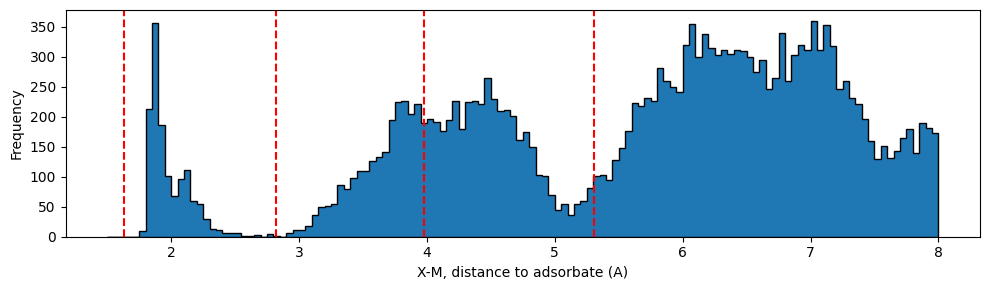

In [12]:
import numpy as np

list_distances = np.array([])
for atoms in fc.df.Atoms:
    d_matrix = atoms.get_all_distances()
    distances_CO = d_matrix[55]
    # concat distances to list
    list_distances = np.concatenate([list_distances, distances_CO])

# plot histogram of distances to CO
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 3))
plt.hist(list_distances, bins=np.arange(1.5, 8.05, 0.05), edgecolor='black', histtype='stepfilled')
plt.xlabel('X-M, distance to adsorbate (A)')
plt.ylabel('Frequency')

# create vertical lines for cutoffs
for cutoff in cutoffs:
    plt.axvline(cutoff, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## From the prev Notebook

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

def extract_features(df, features):
    if features is None:
        feature_cols = df.columns()
    else:
        feature_cols = [col for col in df.columns if any(feature in col for feature in features)]
    return feature_cols

def preprocess_data(df, listfeatures, response, scaler):
    X = df[listfeatures]
    y = df[response]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    if scaler:
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)

    return X, y, X_train, X_test, y_train, y_test

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)   # For the background points in the plot
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, mae, r2, y_pred_train, y_pred

def cross_validate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    return -cv_scores.mean(), -cv_mae_scores.mean()

def plot_results(y_train, y_pred_train, y_test, y_pred, thr_error=0.15, typeerror='individual'):
    # thr_error: threshold for highlighting points with error > threshold
    # typeerror: 'individual' or 'region'

    plt.figure(figsize=(6, 6))
    
    # Diagonal line
    min_val = min(y_train.min(), y_test.min())
    max_val = max(y_train.max(), y_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], '-k', lw=1.)
    
    
    # Scatter plots for Train and Test
    sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.2, s=70, facecolor='coral', edgecolor='black', label='Train')
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=70, facecolor='royalblue', edgecolor='black', label='Test')
    
    # Highlight points with error > threshold
    if typeerror == 'individual':
        for true_value, pred_value in zip(y_test, y_pred):
            if abs(pred_value - true_value) > thr_error:
                plt.plot([true_value, true_value], [true_value, pred_value], '-', lw=1, color='black')
    elif typeerror == 'region':
        # Error threshold lines
        plt.plot([min_val, max_val], [min_val + thr_error, max_val + thr_error], '--k', lw=0.5, label=f'Error ($\pm${thr_error} eV)')
        plt.plot([min_val, max_val], [min_val - thr_error, max_val - thr_error], '--k', lw=0.5)
    
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Values')
    plt.legend(frameon=False)
    plt.show()

def regression_model_analysis(df, response, model, features=None, scaler=False, plot=False, thr_error=0.1, typeerror='individual'):
    listfeatures = extract_features(df, features)
    X, y, X_train, X_test, y_train, y_test = preprocess_data(df, listfeatures, response, scaler)
    model, mse, mae, r2, y_pred_train, y_pred = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    cv_mse, cv_mae = cross_validate_model(model, X, y)
    if plot:
        plot_results(y_train, y_pred_train, y_test, y_pred, thr_error=thr_error, typeerror=typeerror)
    return {
        'Test MSE': mse,
        'Test MAE': mae,
        'Test R-squared': r2,
        'CV MSE': cv_mse,
        'CV MAE': cv_mae,
        'Features': listfeatures,
    }, model

def optimize_model_hyperparameters(model, X_train, y_train, X_test, y_test, 
                hyperparameters, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1):
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    #cv_score = grid_search.cv_results_['mean_test_score']

    # Create a model with the best parameters
    optimized_model = model.__class__(**best_parameters)

    # Train the model
    optimized_model.fit(X_train, y_train)

    # Predict on the test set  
    y_pred = optimized_model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('Best parameters:', best_parameters)
    print('Best CV score:', best_score)

    return optimized_model, mae, r2

## Linear Regression

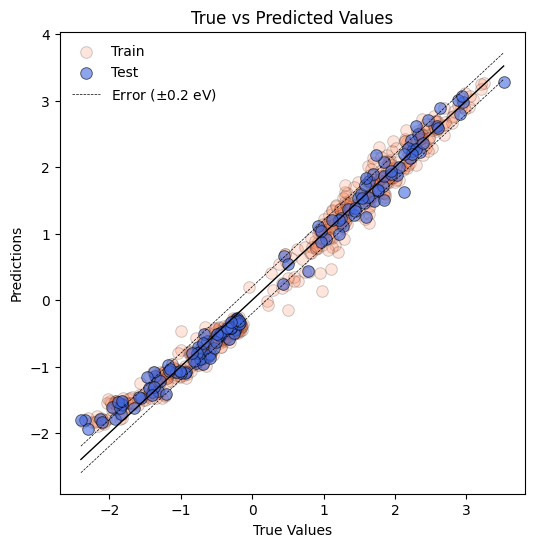

{'Test MSE': 0.034221077612676,
 'Test MAE': 0.14641811872472613,
 'Test R-squared': 0.9851740749124637,
 'CV MSE': 0.045505657676194466,
 'CV MAE': 0.1677768571191007,
 'Features': ['ads_CO',
  'ads_N',
  'R0_Ag',
  'R0_Au',
  'R0_Cu',
  'R0_Pd',
  'R0_Pt',
  'R1_Ag',
  'R1_Au',
  'R1_Cu',
  'R1_Pd',
  'R1_Pt',
  'R2_Ag',
  'R2_Au',
  'R2_Cu',
  'R2_Pd',
  'R2_Pt',
  'R3_Ag',
  'R3_Au',
  'R3_Cu',
  'R3_Pd',
  'R3_Pt']}

In [13]:
df2 = df.copy()

features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']

model = LinearRegression()
results, model = regression_model_analysis(df2, 'Eads', model, features=features, scaler=False, plot=True, thr_error=0.2, typeerror='region')
results

## Support Vector Machine

In [22]:
## WARNING: This cell may take a long time to run (15 min or more)

from sklearn import svm

features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']
model = svm.SVR()
hyperparameters = {
    'kernel': ['poly'],
    'degree': [2, 3],
    'C': [0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [10, 40, 60],
}

listfeatures = extract_features(df2, features)
X, y, X_train, X_test, y_train, y_test = preprocess_data(df2, listfeatures, 'Eads', scaler=False)

model, mae, r2 = optimize_model_hyperparameters(model, X_train, y_train, X_test, y_test, 
                            hyperparameters, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

print('MAE:', mae)
print('R-squared:', r2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'C': 1, 'coef0': 60, 'degree': 2, 'epsilon': 0.05, 'kernel': 'poly'}
Best CV score: -0.10581062037972418
MAE: 0.09504615517625942
R-squared: 0.9925489716093596


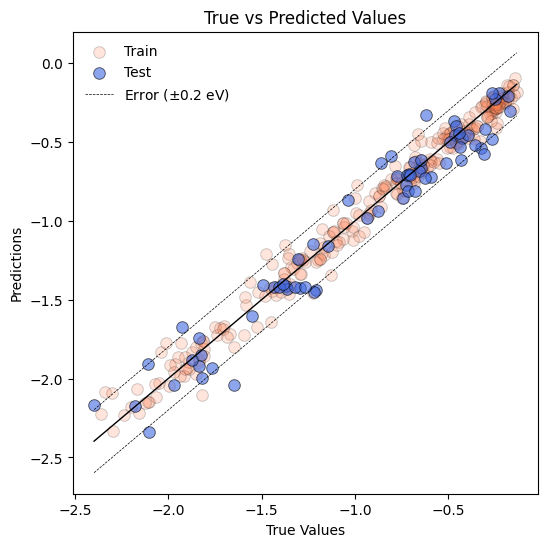

{'Test MSE': 0.01817371830260022,
 'Test MAE': 0.10362336103145631,
 'Test R-squared': 0.9484421726412077,
 'CV MSE': 0.013725107490921155,
 'CV MAE': 0.08881976001133435,
 'Features': ['ads_CO',
  'ads_N',
  'R0_Ag',
  'R0_Au',
  'R0_Cu',
  'R0_Pd',
  'R0_Pt',
  'R1_Ag',
  'R1_Au',
  'R1_Cu',
  'R1_Pd',
  'R1_Pt',
  'R2_Ag',
  'R2_Au',
  'R2_Cu',
  'R2_Pd',
  'R2_Pt',
  'R3_Ag',
  'R3_Au',
  'R3_Cu',
  'R3_Pd',
  'R3_Pt']}

In [17]:
from sklearn import svm

df2 = df
df2 = df2[df2['ads_CO'] == 1]
features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']
model = svm.SVR(kernel="poly", C=1, degree=2, epsilon=0.05, coef0=60)
results, model = regression_model_analysis(df2, 'Eads', model, features=features, scaler=False, plot=True, thr_error=0.2, typeerror='region')
results

### SAVE model to PICKLE file

In [11]:
import pickle

with open('svm_model_676dp_N_CO.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
from xgboost import XGBRegressor

features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']
model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, objective='reg:squarederror', random_state=1)
hyperparameters = {
    'n_estimators': [150, 200, 250],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.07, 0.1],
    'gamma': [0],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0, 0.1, 1, 10],
    'max_leaves': [0]
}

listfeatures = extract_features(df, features)
X, y, X_train, X_test, y_train, y_test = preprocess_data(df, listfeatures, 'Eads', scaler=False)

model, mae, r2 = optimize_model_hyperparameters(model, X_train, y_train, X_test, y_test, 
                            hyperparameters, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

print('MAE:', mae)
print('R-squared:', r2)

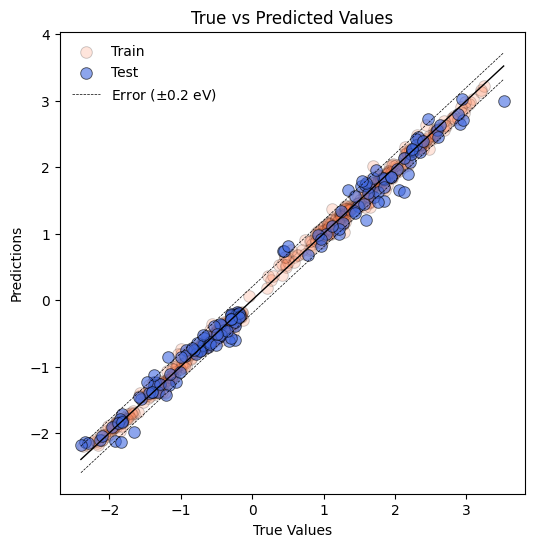

{'Test MSE': 0.02671889422995395,
 'Test MAE': 0.12258549624869045,
 'Test R-squared': 0.9884243176454394,
 'CV MSE': 0.032994416523926005,
 'CV MAE': 0.13476987654833855,
 'Features': ['ads_CO',
  'ads_N',
  'R0_Ag',
  'R0_Au',
  'R0_Cu',
  'R0_Pd',
  'R0_Pt',
  'R1_Ag',
  'R1_Au',
  'R1_Cu',
  'R1_Pd',
  'R1_Pt',
  'R2_Ag',
  'R2_Au',
  'R2_Cu',
  'R2_Pd',
  'R2_Pt',
  'R3_Ag',
  'R3_Au',
  'R3_Cu',
  'R3_Pd',
  'R3_Pt']}

In [19]:
from xgboost import XGBRegressor

features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.03, objective='reg:squarederror', random_state=1, gamma=0, reg_alpha=0, reg_lambda=1, max_leaves=0)
results, model = regression_model_analysis(df, 'Eads', model, features=features, scaler=False, plot=True, thr_error=0.2, typeerror='region')
results

## Scan the CUTOFFS for LinearRegression

## ATTEMPT to optimize CUTOFFS via scipy.optimize.minimize

In [227]:
def objective_function(cutoffs, model, df, response, features=None, scaler=False):
    cutoffs = cutoffs
    print(cutoffs)
    df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
    results, model = regression_model_analysis(df, response, model, features=features, scaler=scaler, plot=False)
    print(f'R2: {results["Test R-squared"]:.4f} - MAE: {results["CV MAE"]:.5f}')
    return results['CV MAE']

from scipy.optimize import minimize

#model = LinearRegression()
model = svm.SVR(kernel="poly", C=0.5, degree=2, epsilon=0.05, coef0=40)
features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_']
response = 'Eads'
scaler = False

initial_guess = [2.44, 3.95, 4.98, 6.00]

# Constraints are that the cutoffs must be in ascending order
constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[2] - x[1]},
               {'type': 'ineq', 'fun': lambda x: x[3] - x[2]}]

# Bounds for the cutoffs. The max value is 10.0
bounds = [(1.5, 8.)] * len(initial_guess)
print(bounds)

result = minimize(objective_function, initial_guess, tol=1e-6,
                  args=(model, df, response, features, scaler), method='SLSQP', jac='2-point',
                  bounds=bounds, constraints=constraints, options={'finite_diff_rel_step': 0.01, 'disp': True})
result

[(1.5, 8.0), (1.5, 8.0), (1.5, 8.0), (1.5, 8.0)]
[2.44 3.95 4.98 6.  ]
R2: 0.9885 - MAE: 0.12074
[2.4644 3.95   4.98   6.    ]
R2: 0.9889 - MAE: 0.12039
[2.44   3.9895 4.98   6.    ]
R2: 0.9878 - MAE: 0.12175
[2.44   3.95   5.0298 6.    ]
R2: 0.9890 - MAE: 0.12033
[2.44 3.95 4.98 6.06]
R2: 0.9896 - MAE: 0.12183
[2.45452389 3.9245132  4.98828311 5.98186986]
R2: 0.9893 - MAE: 0.11897
[2.47906913 3.9245132  4.98828311 5.98186986]
R2: 0.9895 - MAE: 0.11897
[2.45452389 3.96375833 4.98828311 5.98186986]
R2: 0.9886 - MAE: 0.11928
[2.45452389 3.9245132  5.03816594 5.98186986]
R2: 0.9890 - MAE: 0.11943
[2.45452389 3.9245132  4.98828311 6.04168856]
R2: 0.9899 - MAE: 0.11840
[2.45727664 3.91233741 4.98094415 5.98795803]
R2: 0.9890 - MAE: 0.12156
[2.45479917 3.92329562 4.98754921 5.98247868]
R2: 0.9892 - MAE: 0.11901
[2.45457348 3.92429387 4.98815091 5.98197953]
R2: 0.9891 - MAE: 0.11917
[2.45452885 3.92449126 4.98826989 5.98188083]
R2: 0.9891 - MAE: 0.11917
[2.45452439 3.924511   4.98828178 5.981

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.11897250060546294
       x: [ 2.455e+00  3.925e+00  4.988e+00  5.982e+00]
     nit: 2
     jac: [-2.050e-04  7.959e-03  9.101e-03 -9.598e-03]
    nfev: 21
    njev: 2

In [228]:
result.x

array([2.45452389, 3.92451319, 4.9882831 , 5.98186986])

### 5 Parameters

In [16]:
from sklearn import svm

def objective_function(cutoffs, model, df, response, features=None, scaler=False):
    cutoffs = cutoffs
    print(cutoffs)
    df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
    results, model = regression_model_analysis(df, response, model, features=features, scaler=scaler, plot=False)
    print(f'R2: {results["Test R-squared"]:.4f} - MAE: {results["CV MAE"]:.5f}')
    return results['CV MAE']

from scipy.optimize import minimize

#model = LinearRegression()
model = svm.SVR(kernel="poly", C=0.5, degree=2, epsilon=0.05, coef0=40)
features = ['ads_', 'R0_', 'R1_', 'R2_', 'R3_', 'R4_']
response = 'Eads'
scaler = False

initial_guess = [2., 2.8, 3.95, 4.98, 6.00]

# Constraints are that the cutoffs must be in ascending order
constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[2] - x[1]},
               {'type': 'ineq', 'fun': lambda x: x[3] - x[2]},
               {'type': 'ineq', 'fun': lambda x: x[4] - x[3]}
            ]

# Bounds for the cutoffs. The max value is 10.0
bounds = [(1.5, 8.)] * len(initial_guess)
print(bounds)

result = minimize(objective_function, initial_guess, tol=1e-6,
                  args=(model, df2, response, features, scaler), method='SLSQP', jac='2-point',
                  bounds=bounds, constraints=constraints, options={'finite_diff_rel_step': 0.05, 'disp': True})
result

[(1.5, 8.0), (1.5, 8.0), (1.5, 8.0), (1.5, 8.0), (1.5, 8.0)]
[2.   2.8  3.95 4.98 6.  ]
R2: 0.9882 - MAE: 0.11971
[2.1  2.8  3.95 4.98 6.  ]
R2: 0.9891 - MAE: 0.12007
[2.   2.94 3.95 4.98 6.  ]
R2: 0.9883 - MAE: 0.11957
[2.     2.8    4.1475 4.98   6.    ]
R2: 0.9894 - MAE: 0.11969
[2.    2.8   3.95  5.229 6.   ]
R2: 0.9881 - MAE: 0.11848
[2.   2.8  3.95 4.98 6.3 ]
R2: 0.9900 - MAE: 0.12223
[1.9964199  2.80097462 3.95008473 4.98491651 5.99157888]
R2: 0.9887 - MAE: 0.11869
[2.0962409  2.80097462 3.95008473 4.98491651 5.99157888]
R2: 0.9893 - MAE: 0.12039
[1.9964199  2.94102335 3.95008473 4.98491651 5.99157888]
R2: 0.9883 - MAE: 0.11894
[1.9964199  2.80097462 4.14758897 4.98491651 5.99157888]
R2: 0.9900 - MAE: 0.11874
[1.9964199  2.80097462 3.95008473 5.23416234 5.99157888]
R2: 0.9880 - MAE: 0.12020
[1.9964199  2.80097462 3.95008473 4.98491651 6.29115783]
R2: 0.9904 - MAE: 0.12164
[1.71359254 2.84592367 3.95339594 5.22627539 5.47698336]
R2: 0.9911 - MAE: 0.11407
[1.79927217 2.84592367 3.

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10727181454788959
       x: [ 1.628e+00  2.821e+00  3.975e+00  5.303e+00  5.303e+00]
     nit: 5
     jac: [ 0.000e+00  4.778e-02  2.332e-02  2.811e-02  2.900e-02]
    nfev: 44
    njev: 5

In [17]:
result.x

array([1.62778481, 2.82065777, 3.9746458 , 5.30260376, 5.30260376])

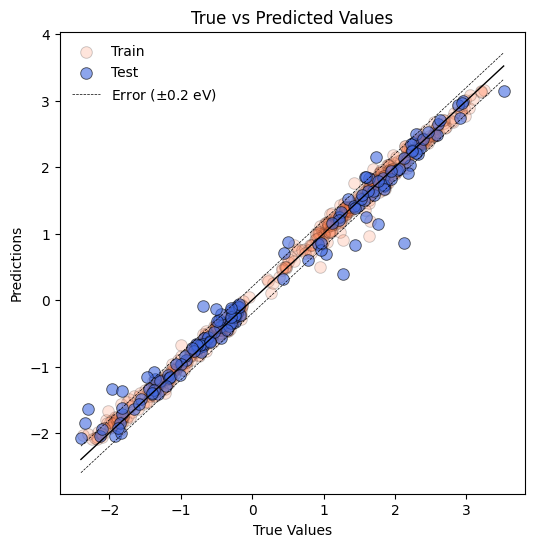

{'Test MSE': 0.05372346171460002,
 'Test MAE': 0.14209122044846184,
 'Test R-squared': 0.9767248703317061,
 'CV MSE': 0.07035569994582051,
 'CV MAE': 0.17500946702593,
 'Features': ['R0_Ag',
  'R0_Au',
  'R0_Cu',
  'R0_Pd',
  'R0_Pt',
  'R1_Ag',
  'R1_Au',
  'R1_Cu',
  'R1_Pd',
  'R1_Pt',
  'R2_Ag',
  'R2_Au',
  'R2_Cu',
  'R2_Pd',
  'R2_Pt']}

In [241]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor( hidden_layer_sizes=(100,100,50,50), alpha=1, random_state=9, max_iter=1000, activation='relu', solver='adam')
results, model = regression_model_analysis(df, 'Eads', model, features=features, scaler=True, plot=True, thr_error=0.2, typeerror='region')
results